In [1]:
import numpy as np
from scipy.integrate import odeint
import importlib
import os
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=16)

<center><h2>ODE and Solver</h2></center>

From Kolb and Thachev (1994) the equation of motion for a spherical shell bounding a region of overdensity $\Phi$ is given by

\begin{equation}
    x(1+x)\frac{d^2R}{dx^2} + \Big(1 + \frac{3}{2}x\Big) +\frac{1}{2}\Big(\frac{1+\Phi}{R^2} - R\Big) = 0
\end{equation}

In [18]:
# Cosmological parameters
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)

def KTode(y, x, params):
    R, w = y
    phi = params[0]
    if R >= 0.001:
        dwdx = -1/(x*(1+x))*((1 + 1.5*x)*w + 0.5*((1+phi)/R**2 - R))
    else:
        dwdx = 0
    derivs = [w, dwdx]
    return derivs

def KTsolve(x, phis, y0 = [1,0]):
    '''
    Solves single shell spherical collapse
    
    x: array - scale factor a/a_eq
    phis: array - overdensities
    y0: list [Initial R, Initial dR/dx]
    '''
    index = np.arange(0, len(x))
    R = np.zeros(len(phis), dtype='object'); xTA = np.zeros(len(phis)); RTA = np.zeros(len(phis))
    for i in range(len(phis)):
        params = [phis[i]]
        psoln = odeint(KTode, y0, x, args=(params,))
        R[i] = psoln[:,0]
        mindex = np.where(psoln[:,0]*x == max(psoln[:,0]*x))[0][0]
        #print(len(x), mindex)
        xTA[i] = x[mindex]
        RTA[i] = psoln[:,0][mindex]
    return [R, xTA, RTA]

In [14]:
phis = np.logspace(-8, 3, int(1e2))
x = np.logspace(-10, 10, int(5e6))
R, xTa, RTA = KTsolve(x, phis)

xCol = np.zeros(len(R))
for i in range(len(R)):
    xCol[i] = max(x[R[i]>0])
    
# Need to rewrite this section to save the data and if it already exists then load.

5.050911010182203


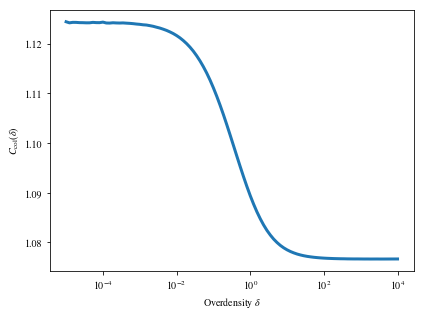

In [4]:
plt.figure(figsize = (6,4.5))
plt.semilogx(phis, xCol*phis, lw = 3)
plt.ylabel("$C_{\mathrm{col}}(\delta)$")
plt.xlabel("Overdensity $\delta$")
plt.tight_layout()
plt.savefig("CollapseConstant.pdf")

print(np.log10(max(xCol)))

<center><h2>Linear growth solution</h2></center>

For CDM in the presence of radiation

\begin{equation}
    x^2(1+x^{-3w})\frac{d^2\delta}{dx^2} + \frac{3}{2}x(1 + (1-w)x^{-3w})\frac{d\delta}{dx} - \frac{3}{2}\delta = 0.
\end{equation}

Setting $w = 1/3$, the general solution is found to be

\begin{equation}
    \delta(x) = C_1\Big(1+\frac{3}{2}x\Big) + C_2\Big[\Big(1 + \frac{3}{2}x\Big)\ln\frac{\sqrt{1+x}+1}{\sqrt{1+x}-1} - 3\sqrt{1+x}\Big],
\end{equation}

where $C_1$ and $C_2$ are constants that are fixed by the initial conditions. 

Since we are considering a single isocurvature mode in the subhorizon limit the initial conditions are determined by

\begin{equation}
    \delta(t=0) = 1, \\
    \frac{d\delta}{dt}\Big|_{t=0} =0
\end{equation}

and since

\begin{equation}
    \frac{d\delta}{dt} = \frac{d\delta}{dx}H(x)x,
\end{equation}
but $H(x)$ and $x$ are both nonzero, so we require

\begin{equation}
    \frac{d\delta}{dx} = 0.
\end{equation}

In the limit of small $x$ 

\begin{equation}
    \delta(x) = (C_1 - 3C_2) - C_2\ln\Big(\frac{x}{4}\Big) + \mathcal{O}(x),
\end{equation}

therefore $C_1 = 1$, $C_2 = 0$.

In [19]:
def GrowthFactor(x, C1, C2):
    
    C1term1 =  (1+3/2*x)
    C2term1 = (1+3/2*x)*np.log((np.sqrt(1+x)+1)/(np.sqrt(1+x)-1))
    C2term2 =  - 3*np.sqrt(1+x)
    
    return C1*C1term1 + C2*(C2term1 + C2term2)

Max error in fit = 2.02%


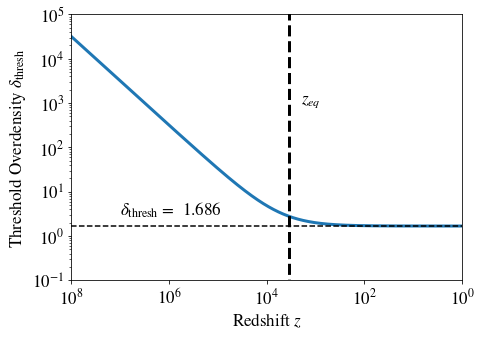

In [31]:
C1 = 1; C2 = 0

matplotlib.rc('font', size=17)
def GrowthFactor(x, C1, C2):
    
    C1term1 =  (1+3/2*x)
    C2term1 = (1+3/2*x)*np.log((np.sqrt(1+x)+1)/(np.sqrt(1+x)-1))
    C2term2 =  - 3*np.sqrt(1+x)
    
    return C1*C1term1 + C2*(C2term1 + C2term2)

# Calculate linear density
DCol = GrowthFactor(xCol, C1, C2)
philin = phis*DCol

fig = plt.figure(figsize=(7,5))
ax3 = fig.add_subplot(111)


def PhiLinFit(phi, A):
    return (1+A*phi**(-1))

A = curve_fit(PhiLinFit, phis, philin/phis)[0][0]
D = GrowthFactor(x, C1, C2)
maxError = max(abs(philin - PhiLinFit(phis, A)*phis)/(philin))

Thresh = A*D/(D-1)
ax3.loglog(1/(x*a_eq)-1, Thresh,lw=3)

# Asymtotic matter dom behaviour
ax3.loglog([min(1/(x*a_eq)-1),max(1/(x*a_eq)-1)],[A, A],'k--')
ax3.loglog([1/a_eq-1,1/a_eq-1],[1e-4,1e11],'k--', lw = 3)
ax3.set_xlim([1e8, 1])
ax3.set_ylim([1e-1, 1e5])
ax3_text1 = "$\delta_{\mathrm{thresh}}$ = "; ax3_test2 = " {:.4}".format(A)
ax3.annotate(ax3_text1 + ax3_test2, (1e7, 3e0))
ax3.annotate("$z_{eq}$", (2e3, 1e3),color = 'k')

ax3.set_ylabel("Threshold Overdensity $\delta_{\mathrm{thresh}}$")
ax3.set_xlabel("Redshift $z$")
plt.tight_layout()
print("Max error in fit = {:.3}%".format(maxError*100))

In [33]:
np.save("PeakPatch/m3p_merger/FinalGraphs/Data/DensityThreshold.npy",[Thresh, 1/(x*a_eq)-1])

Reducing $x_0$ by 2 orders of magnitude changes the calculated value of $A$ by around 0.02 %. That is, changing $x_0$ does not change the result.